# Ion suppression correction

This notebook establishes the correction workflow using the Co-Culture-Dataset of HeLa and NIH3T3 cells.

In [1]:
import os
import platform
import numpy as np
import pandas as pd
import scanpy as sc
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statistics as st
import anndata as ad
from importlib import reload
import src.correction
from src.correction import *
from src import const
from src.evaluation import plot_all_ion_slopes
%matplotlib inline

In [2]:
if platform.system() == "Darwin":
    target_path = '/Volumes/mklein/FDA_project/data/Mx_Co_Cultured'
else:
    target_path = '/home/mklein/FDA_project/data/Mx_Co_Cultured'


In [3]:
dataset_co_cult = np.load('data/Mx_Co_Cultured/marks_flitered_fluo.npy', allow_pickle = True)

dict_headers = ["norm_MM",
    "cell_marks",
    "nucl_fluo",
    "cell_fluo",
    "marks_fluo",
    "marks_cell_overlap",
    "mark_area",
    "overlap_indices",
    "marks_fluo_overlap",
    "cell_area",
    "marks_cell_overlap_indexes",
    "marks_cellLabels",
    "marks_samplingArea",
    "pmi",
    "overLaps"]

cell_area = dataset_co_cult[9]

# reference, which cells are covered by which marks
cell_marks = dataset_co_cult[1]

# size of every mark
mark_area = dataset_co_cult[6]

# reference of overlap area between cells and marks
marks_cell_overlap = dataset_co_cult[5]



In [4]:
# pickles of tables that result from this comfiguration have suffix "_small"
if(False):
    selected_cells = ['3', '100', '21', '43', '547']
    cell_marks = {k:v for k,v in cell_marks.items() if k in selected_cells}
    marks_cell_overlap = {k:v for k,v in marks_cell_overlap.items() if k in selected_cells}
    selected_pixels = ['2']
    for _, cell in cell_marks.items():
        selected_pixels = selected_pixels + [str(n) for n in cell]

    selected_pixels.sort(key = int)
    mark_area = {k:v for k,v in mark_area.items() if k in selected_pixels}

    selected_pixels

In [5]:
# calculating different cell x pixel matrices
overlap_matrix, sampling_spec_matrix = get_matrices(mark_area=mark_area, marks_cell_associations=cell_marks, marks_cell_overlap=marks_cell_overlap)

sampling_spec_matrix

0    1  2  3  4    5    6  7  8  9  ...  2490  2491  2492  2493  2494  \
1     0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
2     0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
3     0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
4     0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
5     0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
...  ..  ... .. .. ..  ...  ... .. .. ..  ...   ...   ...   ...   ...   ...   
1570  0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
1571  0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
1572  0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
1573  0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   
1574  0  0.0  0  0  0  0.0  0.0  0  0  0  ...   0.0   0.0   0.0   0.0   0.0   

      2495  2496  2497  2498  2499  
1      0.0     0   0.0   0.0   0.0  
2      0.0     0   0.0   0.0   0.0  
3      0.0     0   0.0   0.0   0.0  
4      0.0     0   0.0   0.0   0.0  
5      0.0     0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...  
1570   0.0     0   0.0   0.0   0.0  
1571   0.0     0   0.0   0.0   0.0  
1572   0.0     0   0.0   0.0   0.0  
1573   0.0     0   0.0   0.0   0.0  
1574   0.0     0   0.0   0.0   0.0  

[1572 rows x 2500 columns]

In [6]:
ion_intensities = pd.read_csv('data/Mx_Co_Cultured/sm_annotation_detections.csv')

ion_intensities = ion_intensities.drop(['Num', 'X', 'Y', 'Z', 'R'], axis=1)

# ion_intensities = ion_intensities[['C16H30O2', "C25H44NO7P", "C45H78NO8P"]]
# ion_intensities = ion_intensities.iloc[selected_pixels]

ion_intensities.index = [const.PIXEL_PRE + str(i) for i in ion_intensities.index]
ion_intensities


C10H10N2O3S  C10H10N2O4S  C12H13N3O4S  C12H20N3O6S  C13H16N2O5  \
0       11732.452    996.42834     0.000000     96.63648   251.41237   
1        8926.941    644.85220    98.860180     94.53568   129.45300   
2       16184.508   1443.74080   122.435680    459.26910   298.34604   
3       17386.785   1770.08830     0.000000    521.62244   392.64360   
4       17993.777   2441.13100     0.000000    424.59857   589.03710   
...           ...          ...          ...          ...         ...   
2495    14193.198   1098.00960   377.735440    133.33331     0.00000   
2496    17826.373   2204.89750   124.410450    604.37280   635.19990   
2497    20524.766   2208.07860   131.849640    535.55316   437.42600   
2498    13827.365   1398.90610   117.092980    228.95663    93.65218   
2499     8309.413    777.50710    54.968914      0.00000    68.58983   

       C13H26O2  C14H20N2O3S  C14H20N2O4S  C14H20N2O6S  C14H21N3O3S  ...  \
0     1035.7161    508.46760     776.2968    728.43120    1268.3046  ...   
1     1127.7477    660.01980     798.9810    499.13810    1126.1990  ...   
2      874.1114    869.47440    1570.6218   1599.04420    1897.0496  ...   
3     1581.3160    851.89560    1496.8848   1700.58310    2238.6267  ...   
4     1536.0576   1004.76526    1373.1233   1684.19860    2142.4817  ...   
...         ...          ...          ...          ...          ...  ...   
2495  1268.6356    966.20984    1225.4326   1056.80550    2004.0934  ...   
2496  1172.6652   2027.87210    2225.9185   2475.11870    3223.1426  ...   
2497  1162.7046   1485.94580    1914.0786   1891.50900    3095.1462  ...   
2498   922.5511   1030.80410    1423.4183   1002.28130    2138.9333  ...   
2499  1171.5669    582.49270     802.6624    265.93088    1357.9442  ...   

      C45H78NO8P  C45H80NO8P  C45H82NO7P  C45H82NO8P  C46H77O10P  C46H81NO10P  \
0      263.37576   252.51741         0.0   244.01695     0.00000     99.36901   
1      269.30545   126.23382         0.0   491.70282   340.28522     75.63770   
2        0.00000     0.00000         0.0     0.00000     0.00000      0.00000   
3        0.00000     0.00000         0.0     0.00000     0.00000      0.00000   
4        0.00000     0.00000         0.0     0.00000     0.00000      0.00000   
...          ...         ...         ...         ...         ...          ...   
2495   130.08005   229.90854         0.0   136.83795     0.00000      0.00000   
2496     0.00000     0.00000         0.0     0.00000     0.00000      0.00000   
2497     0.00000     0.00000         0.0     0.00000     0.00000      0.00000   
2498   184.42477   230.75467         0.0   108.41697     0.00000    368.53442   
2499   184.74634   134.13509         0.0   403.94885     0.00000    200.95474   

      C50H84NO10P   C6H11O8P    C6H13O9P   C9H19O11P  
0             0.0  2732.2040  1450.11540  128.282870  
1             0.0  4471.3240  1770.75710  400.891660  
2             0.0   970.5054   616.07654   78.222760  
3             0.0  1037.3005   702.37850    0.000000  
4             0.0  1332.7043   940.42100  120.620830  
...           ...        ...         ...         ...  
2495          0.0  4241.5864  1591.95830  317.245880  
2496          0.0  2617.0530  1362.17570   85.987526  
2497          0.0  3441.5498  2130.13530  101.250000  
2498          0.0  5551.5240  2327.51880  254.901870  
2499          0.0  7431.5723  3101.31710  669.905700  

[2500 rows x 104 columns]

In [7]:
am_adata = ad.AnnData(X = ion_intensities.astype(np.float32))

In [8]:
# this is how martijn performed the calculations
def cell_normalization_Rappez_matrix(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.sum(axis = 0) * pixel_sampling_prop_keep
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    sum_prop_matrix = sampling_prop_matrix_filtered.replace(to_replace=0, value=pd.NA)

    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)
    norm_spots = ion_intensity_matrix.multiply(1/sum_prop_matrix, axis=0).replace(np.nan, 0)
    
    cor_df = sampling_spec_matrix_filtered.replace(np.nan, 0).dot(norm_spots)

    norm_cor_df = cor_df.multiply(1/sampling_spec_matrix_filtered.sum(axis=1), axis=0)
    
    return norm_cor_df



In [9]:
reload(src.correction)
from src.correction import add_normalization_factors, correct_quantile_inplace

add_matrices(adata = am_adata,
    overlap_matrix = overlap_matrix,
    sampling_spec_matrix = sampling_spec_matrix)

add_normalization_factors(adata = am_adata, method = st.median)

corrected_intensities = correct_quantile_inplace(am_adata, 
    reference_ions = ['C21H43O7P'],
    correct_intersect = True)
    

/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


HeLa      715
NIH3T3    492
Name: celltype, dtype: int64


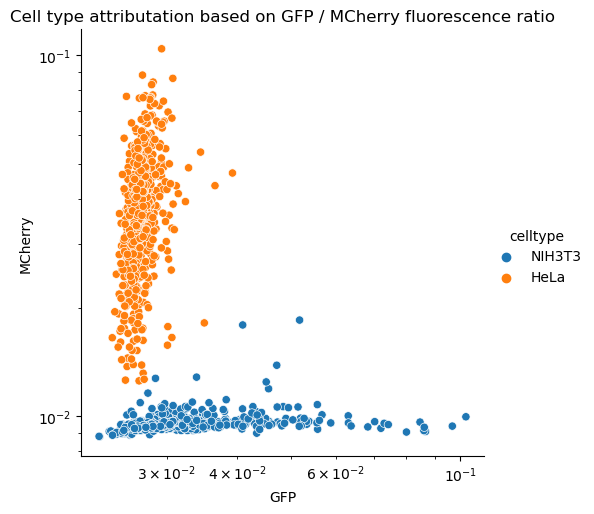

In [10]:
condition_metadata = pd.read_csv(os.path.join(target_path, 'MORPHnMOL.csv'))
condition_metadata.index = [const.CELL_PRE + str(i) for i in condition_metadata.ObjectNumber]
condition_metadata['GFP'] = condition_metadata.Intensity_MeanIntensity_GFP_quantif
condition_metadata['MCherry'] = condition_metadata.Intensity_MeanIntensity_mCherry_quantif
condition_metadata['fluorescence_ratio'] = np.log(condition_metadata.GFP / condition_metadata.MCherry)

#condition_metadata['celltype'] = 'HeLa' if condition_metadata.fluorescence_ratio < 0.8 else 'NIH3T3'
condition_metadata['celltype'] = np.where(condition_metadata.fluorescence_ratio < 0.8, 'HeLa', 'NIH3T3')

print(condition_metadata['celltype'].value_counts())

plot = sns.relplot(data=condition_metadata, x='GFP', y='MCherry', hue='celltype')
plot.set(xscale='log')
plot.set(yscale='log')
plot.set(title='Cell type attributation based on GFP / MCherry fluorescence ratio')

raw_adata = ad.AnnData(obs=condition_metadata[['ObjectNumber', 'celltype', 'GFP', 'MCherry', 'fluorescence_ratio']], var=am_adata.var.loc[am_adata.var.index.intersection(condition_metadata.columns)])



In [11]:
cell_adata = deconvolution_rappez(am_adata, raw_adata=raw_adata)
corr_cell_adata = deconvolution_rappez(corrected_intensities, raw_adata=raw_adata)

In [12]:
def log_log_regression_plot(df, molecule = '', x_axis_name='sampling_proportion', title = 'Regression plot', log_axis = False):
    intensities_df = df.to_df()
    
    if 'correction_quantreg_intersect' in list(df.var.columns):
        intersect = df.var.loc[molecule, 'correction_quantreg_intersect']
        slope = df.var.loc[molecule, 'correction_quantreg_slope']
        print('y = %1.2fx + %1.2f'%(slope,intersect))
        
    x_axis = total_pixel_overlap = df.obs['correction_total_pixel_overlap']
    full_pixel_intensities = df.var['correction_full_pixel_avg_intensities']
    norm_intensity_prop_ratios_df = normalize_proportion_ratios(df, normalized=True).to_df()
    intensities_df[x_axis_name] = total_pixel_overlap
    norm_intensity_prop_ratios_df[x_axis_name] = total_pixel_overlap

    if not molecule in intensities_df.columns:
        molecule = intensities_df.columns[0]
    
    if log_axis:
        intensities_df = np.log10(intensities_df)
        norm_intensity_prop_ratios_df = np.log10(norm_intensity_prop_ratios_df)
        
    fig, ax = plt.subplots(1, 2)

    def render_plot(df, ax, measure, title = ''):

        sns.scatterplot(data=df.dropna(subset = [molecule, x_axis_name]).infer_objects(), x=x_axis_name, y=molecule, ax=ax)
        
        if not log_axis:
            ax.set(xscale="log")
            ax.set(yscale="log")
            
        ax.set(ylabel= measure + " of " + molecule)
        ax.set(title=title)

    render_plot(intensities_df, ax[0], measure = 'intensity', title = title)
    render_plot(norm_intensity_prop_ratios_df, ax[1], measure = 'norm. intensity/sampling prop. ratio', title='intens./sampling prop. ratio')
    
    # if 'correction_quantreg_intersect' in list(df.var.columns):
        # ax[1].axline((0, intersect), slope=slope)

    fig.tight_layout()


y = 0.06x + -0.08


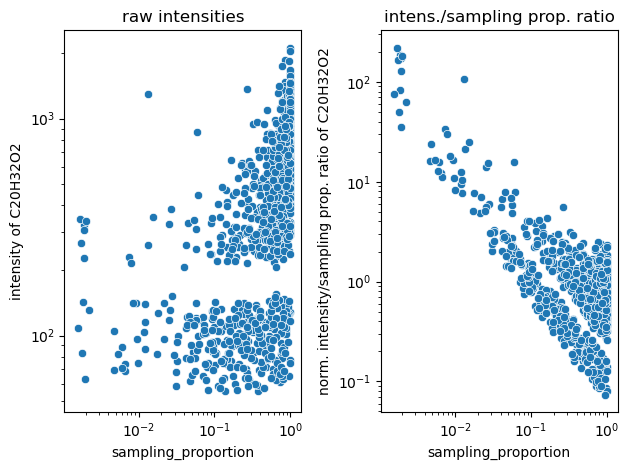

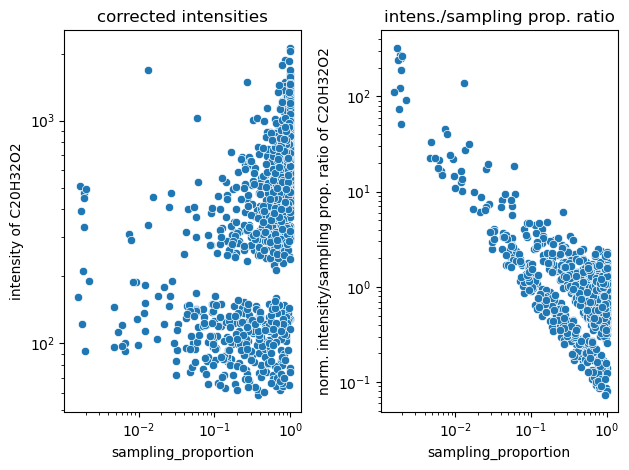

In [13]:
log_log_regression_plot(am_adata, molecule='C20H32O2', title='raw intensities')
log_log_regression_plot(corrected_intensities, molecule='C20H32O2', title='corrected intensities')

y = -0.49x + -0.02


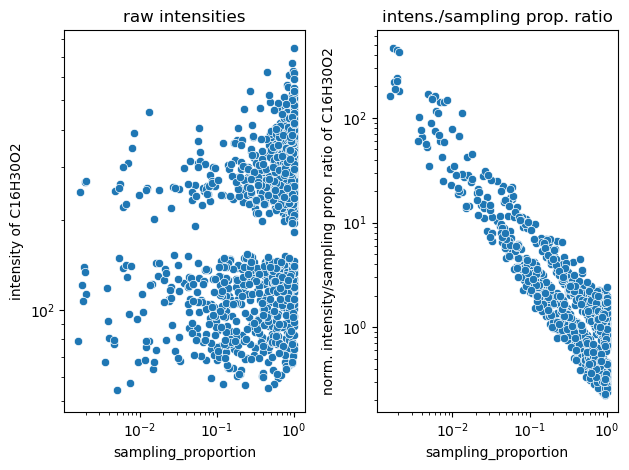

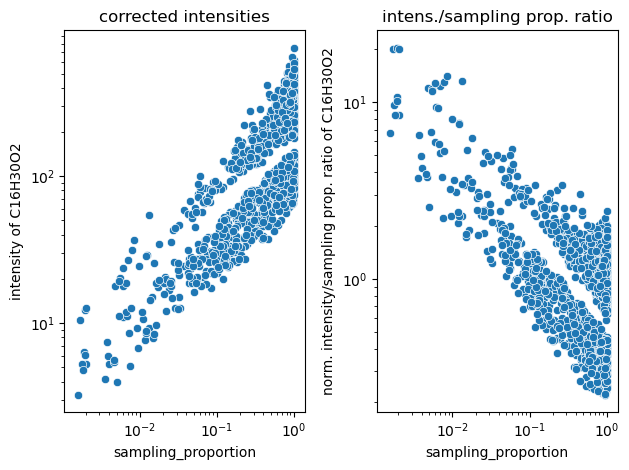

In [14]:
log_log_regression_plot(am_adata, molecule='C16H30O2', title='raw intensities')
log_log_regression_plot(corrected_intensities, molecule='C16H30O2', title='corrected intensities')

y = -1.00x + 0.01


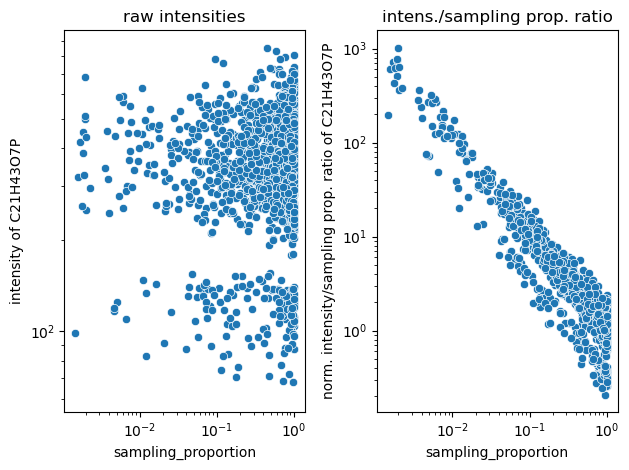

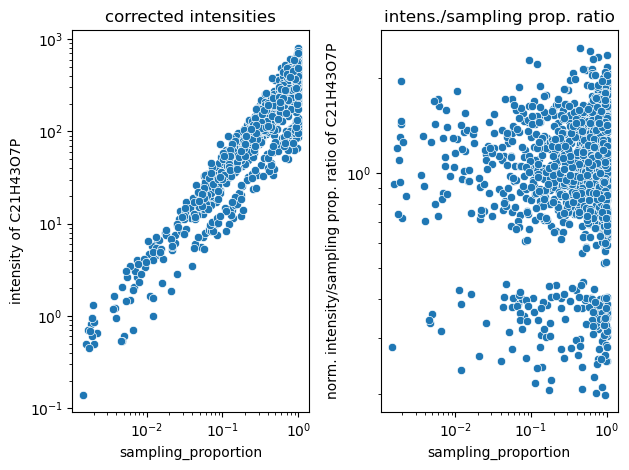

In [15]:
log_log_regression_plot(am_adata, molecule='C21H43O7P', title='raw intensities')
log_log_regression_plot(corrected_intensities, molecule='C21H43O7P', title='corrected intensities')

In [16]:
cell_adata.write(os.path.join(target_path, 'pipeline_files/batch_sm_matrix.h5ad'))
corr_cell_adata.write(os.path.join(target_path, 'pipeline_files/corrected_batch_sm_matrix.h5ad'))

In [17]:
am_adata.write(os.path.join(target_path, 'pipeline_files/am_sm_matrix.h5ad'))
corrected_intensities.write(os.path.join(target_path, 'pipeline_files/corrected_am_sm_matrix.h5ad'))

Different molecules are changed by the ion suppression correction to a different extent. This is not only determined by the data at hand but also by the regression method employed. In the following, the results of quantile regression and other regression methods are shown on different representative molecules. In total on two molecules, quantile regression results in a positive relationship between intensity / sampling proportion ratio and sampling proportion. This is not expected and also does not reflect the visual impression of the regression plot. Other methods, albeit resulting in a negative slope, are also unable to align with the precepted relationship.

In [18]:
from scipy.sparse import csr_matrix
sparse_overlap = csr_matrix(am_adata.obsm['correction_overlap_matrix'])
dict_assoc = sparse_overlap.tocoo(copy=True)
overlap_df = pd.DataFrame({'am': dict_assoc.row, 'ObjectNumber': dict_assoc.col})
overlap_df = pd.merge(overlap_df, cell_adata.obs[['ObjectNumber', 'celltype']], on='ObjectNumber', how='inner')
overlap_df['celltype'] = pd.Categorical(overlap_df['celltype'], categories = ['HeLa', 'NIH3T3', 'mixed', 'none'])
am_adata.obs['cell_condition'] = pd.Categorical([",".join(list(set(overlap_df.loc[overlap_df['am'].astype(str) == am, 'celltype']))) 
    if am in list(overlap_df['am'].astype(str))
    else 'none' 
    for am in am_adata.obs.index])

In [19]:
import statsmodels.api as sm

norm_int = src.correction.normalize_proportion_ratios(am_adata, normalized=True)

/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


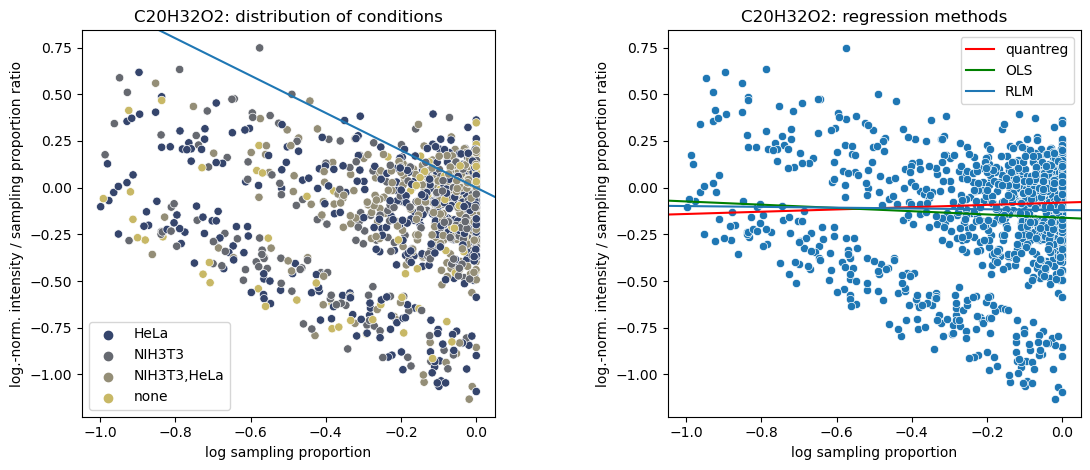

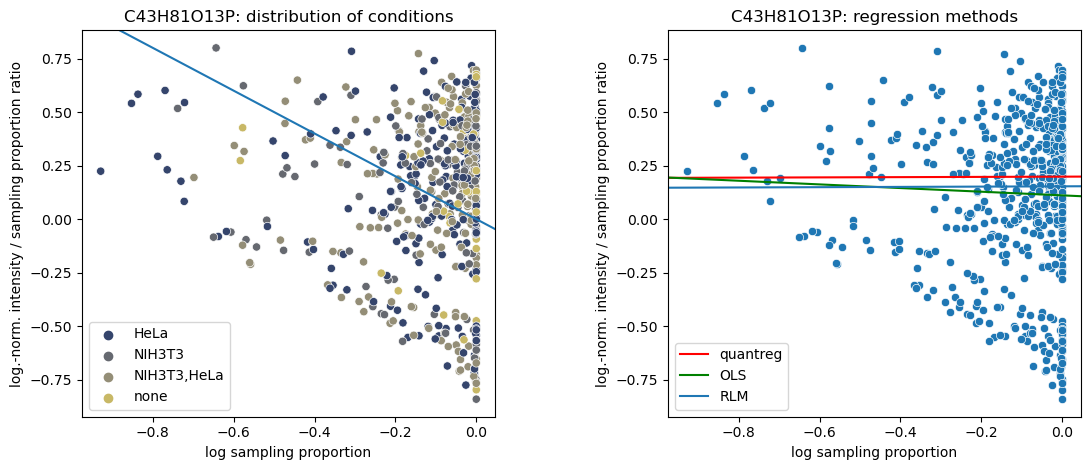

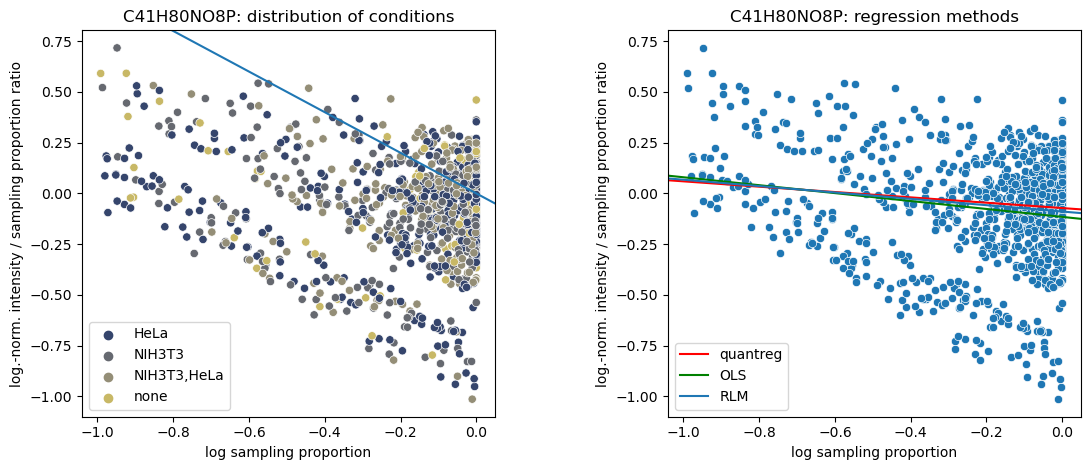

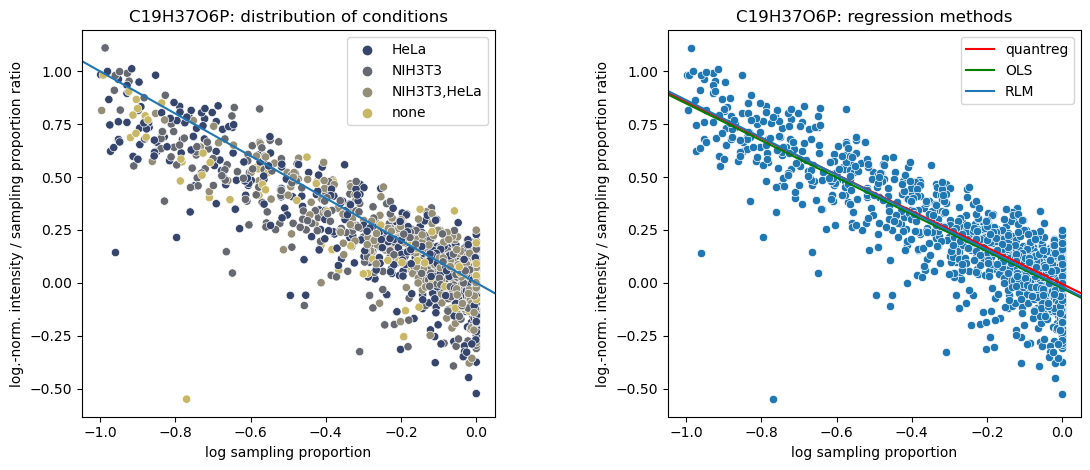

In [20]:
def plot_different_regressions(ion):
    
    df = sc.get.obs_df(norm_int, keys=[ion, const.TPO])
    plot_df = np.log10(df).replace([-np.Inf], np.nan).dropna()
    plot_df = plot_df[plot_df[const.TPO] > np.log10(0.1)]
    plot_df['full'] = ['full' if p == 0.0 else 'not full' for p in plot_df[const.TPO]]
    plot_df['am'] = plot_df.index
    plot_df = pd.merge(plot_df, norm_int.obs[['cell_condition']], how='left', left_index=True, right_index=True)

    fig, ax = plt.subplots(1, 2)

    sns.scatterplot(plot_df, x='correction_total_pixel_overlap', y=ion, ax=ax[0], hue='cell_condition', palette='cividis')
    sns.scatterplot(plot_df, x='correction_total_pixel_overlap', y=ion, ax=ax[1])
    ax[0].axline((0, 0), slope=-1)

    qrmodel = smf.quantreg(ion+' ~ correction_total_pixel_overlap', plot_df).fit(0.5)
    ax[1].axline((0, qrmodel.params[0]), slope=qrmodel.params[1], label = 'quantreg', color='red')

    model = sm.OLS(plot_df[ion], sm.add_constant(plot_df['correction_total_pixel_overlap'])).fit()
    ax[1].axline((0, model.params[0]), slope=model.params[1], label = 'OLS', color='green')

    model = sm.RLM(plot_df[ion], sm.add_constant(plot_df['correction_total_pixel_overlap']), M=sm.robust.norms.HuberT()).fit()
    ax[1].axline((0, model.params[0]), slope=model.params[1], label = 'RLM')
    
    for a in ax:
        a.legend()
        a.set(ylabel='log.-norm. intensity / sampling proportion ratio', xlabel='log sampling proportion')
    
    ax[0].set(title = ion + ": distribution of conditions")
    ax[1].set(title = ion + ": regression methods")

    # print("full pixel average intensity %s: %1.1f"%(ion, norm_int.var.loc[ion, const.FPAI]))
    #print(qrmodel.params)
    fig.tight_layout()
    fig.set_figwidth(12)
    return plot_df


arach_df = plot_different_regressions(ion = 'C20H32O2')
plot_different_regressions(ion = 'C43H81O13P')
plot_different_regressions(ion = 'C41H80NO8P')
_ = plot_different_regressions(ion = 'C19H37O6P')


/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


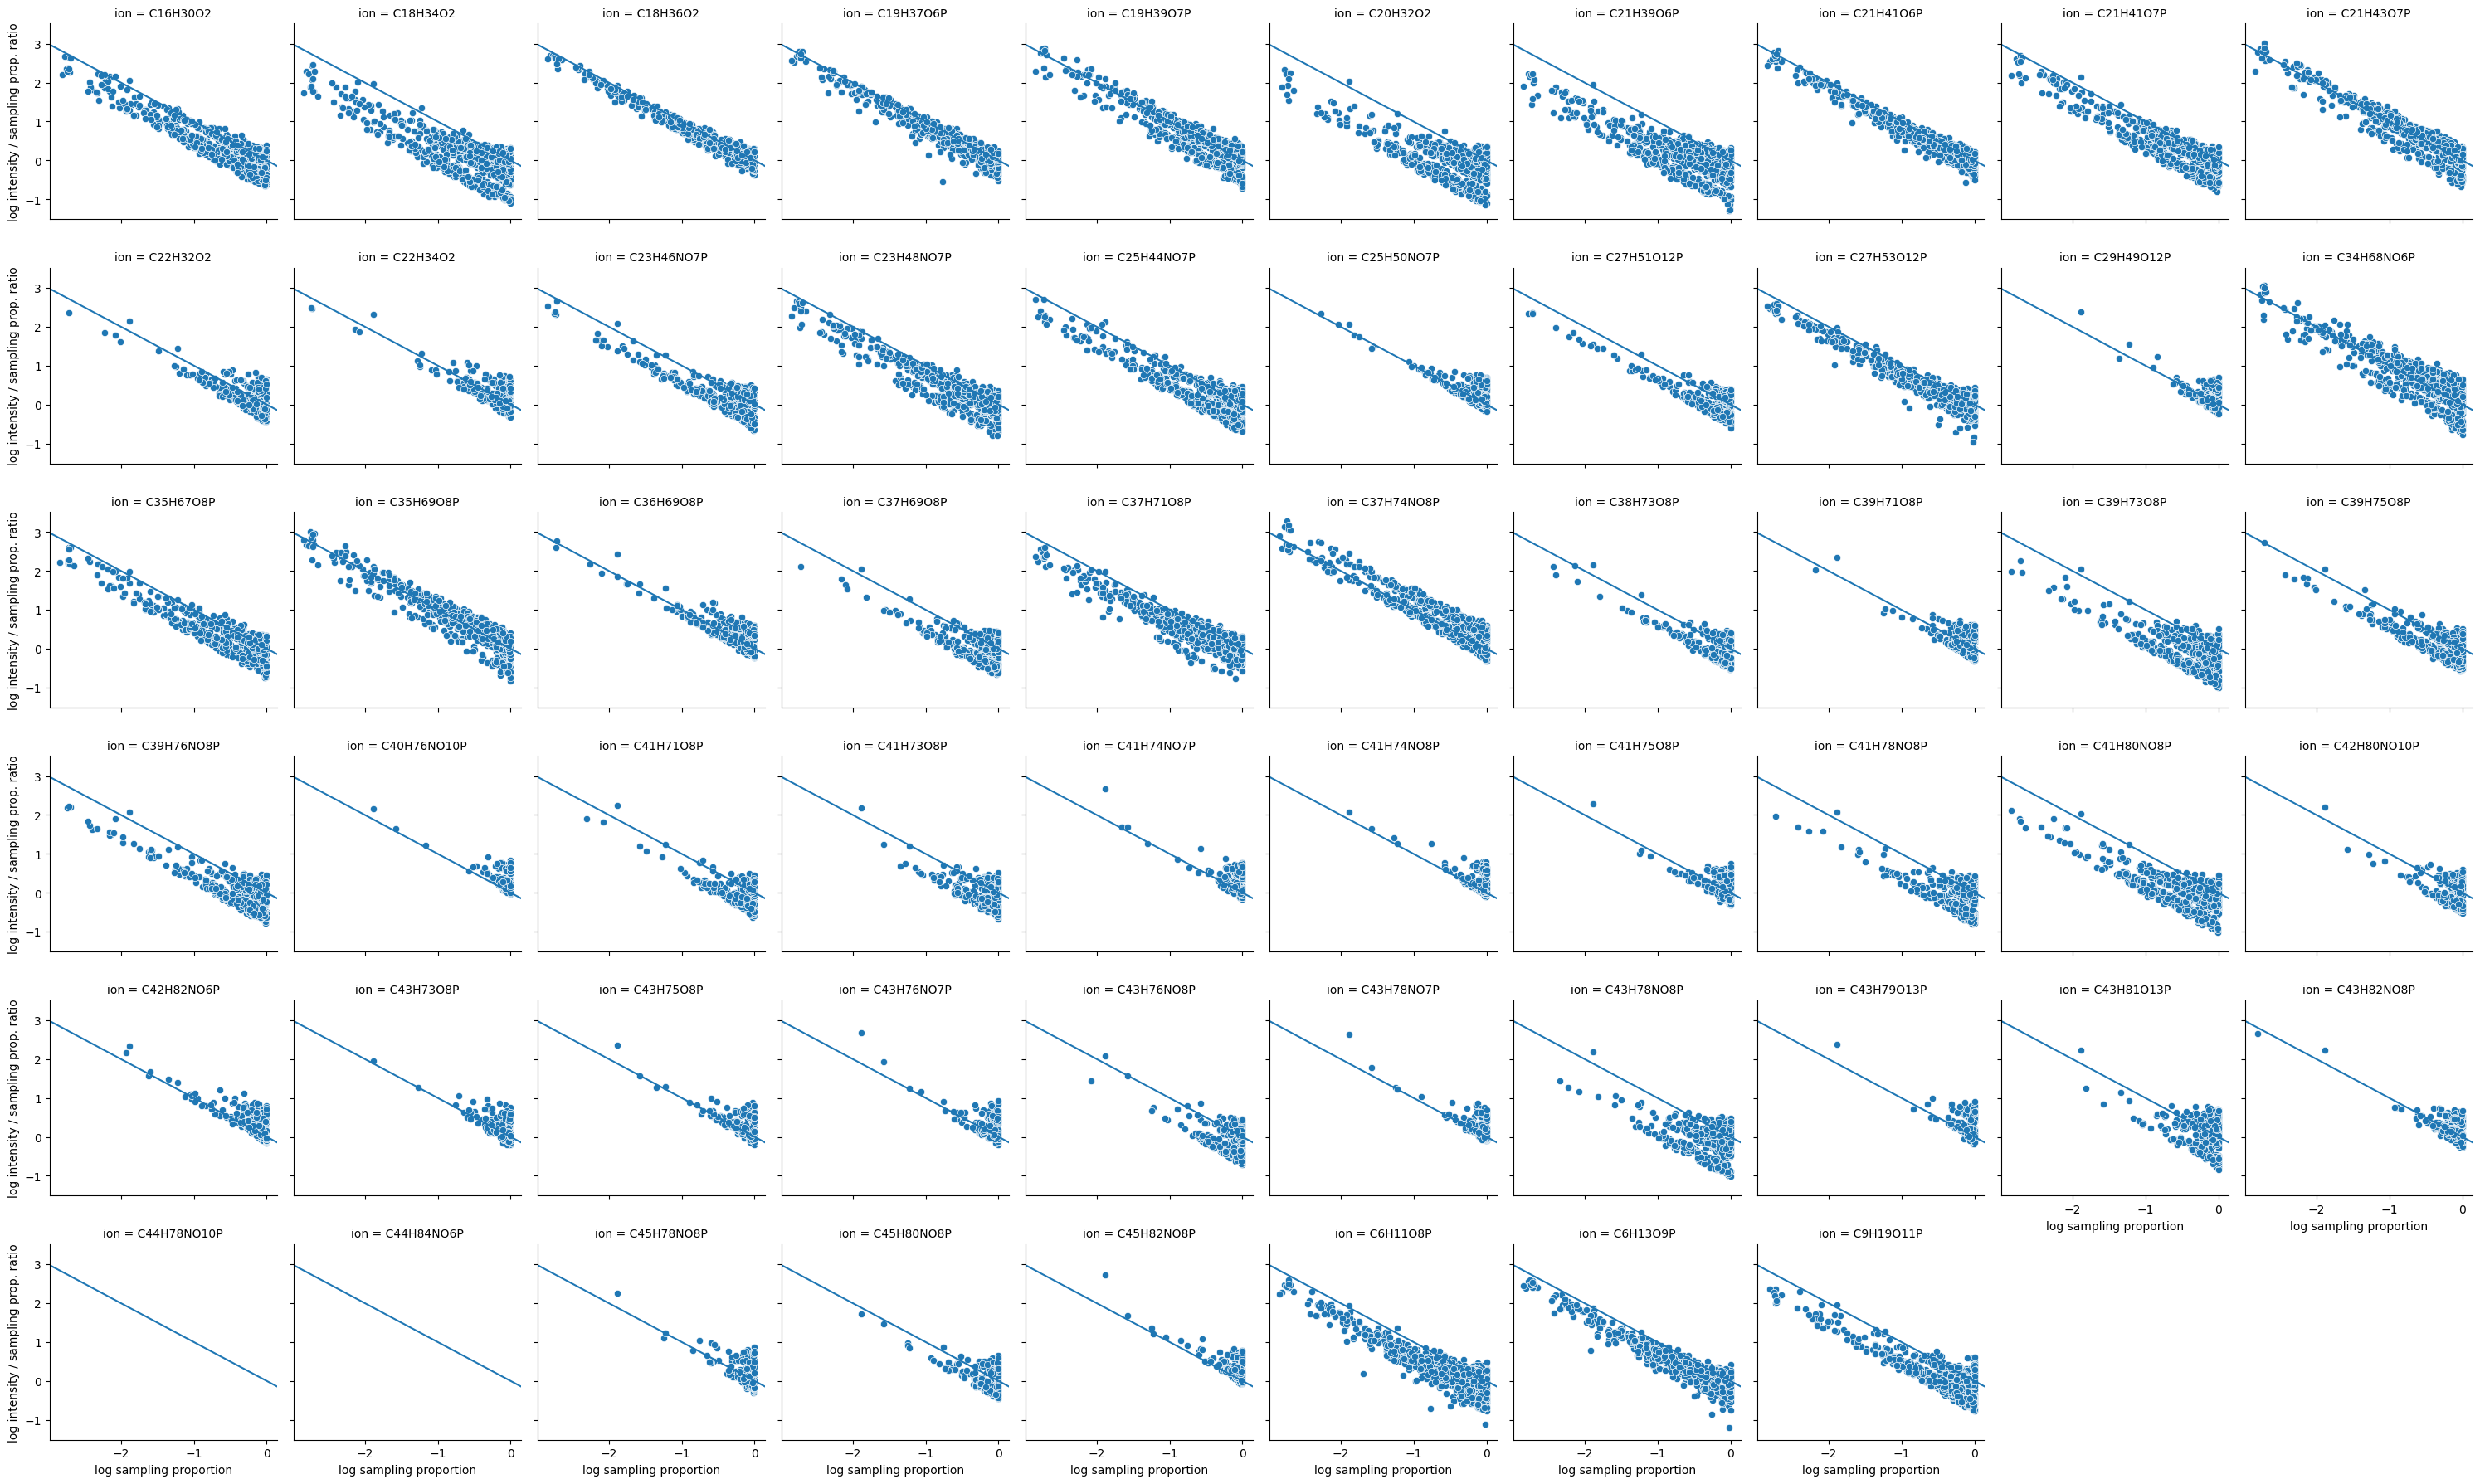

In [21]:
plot_all_ion_slopes(am_adata, subset = raw_adata.var_names)


/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


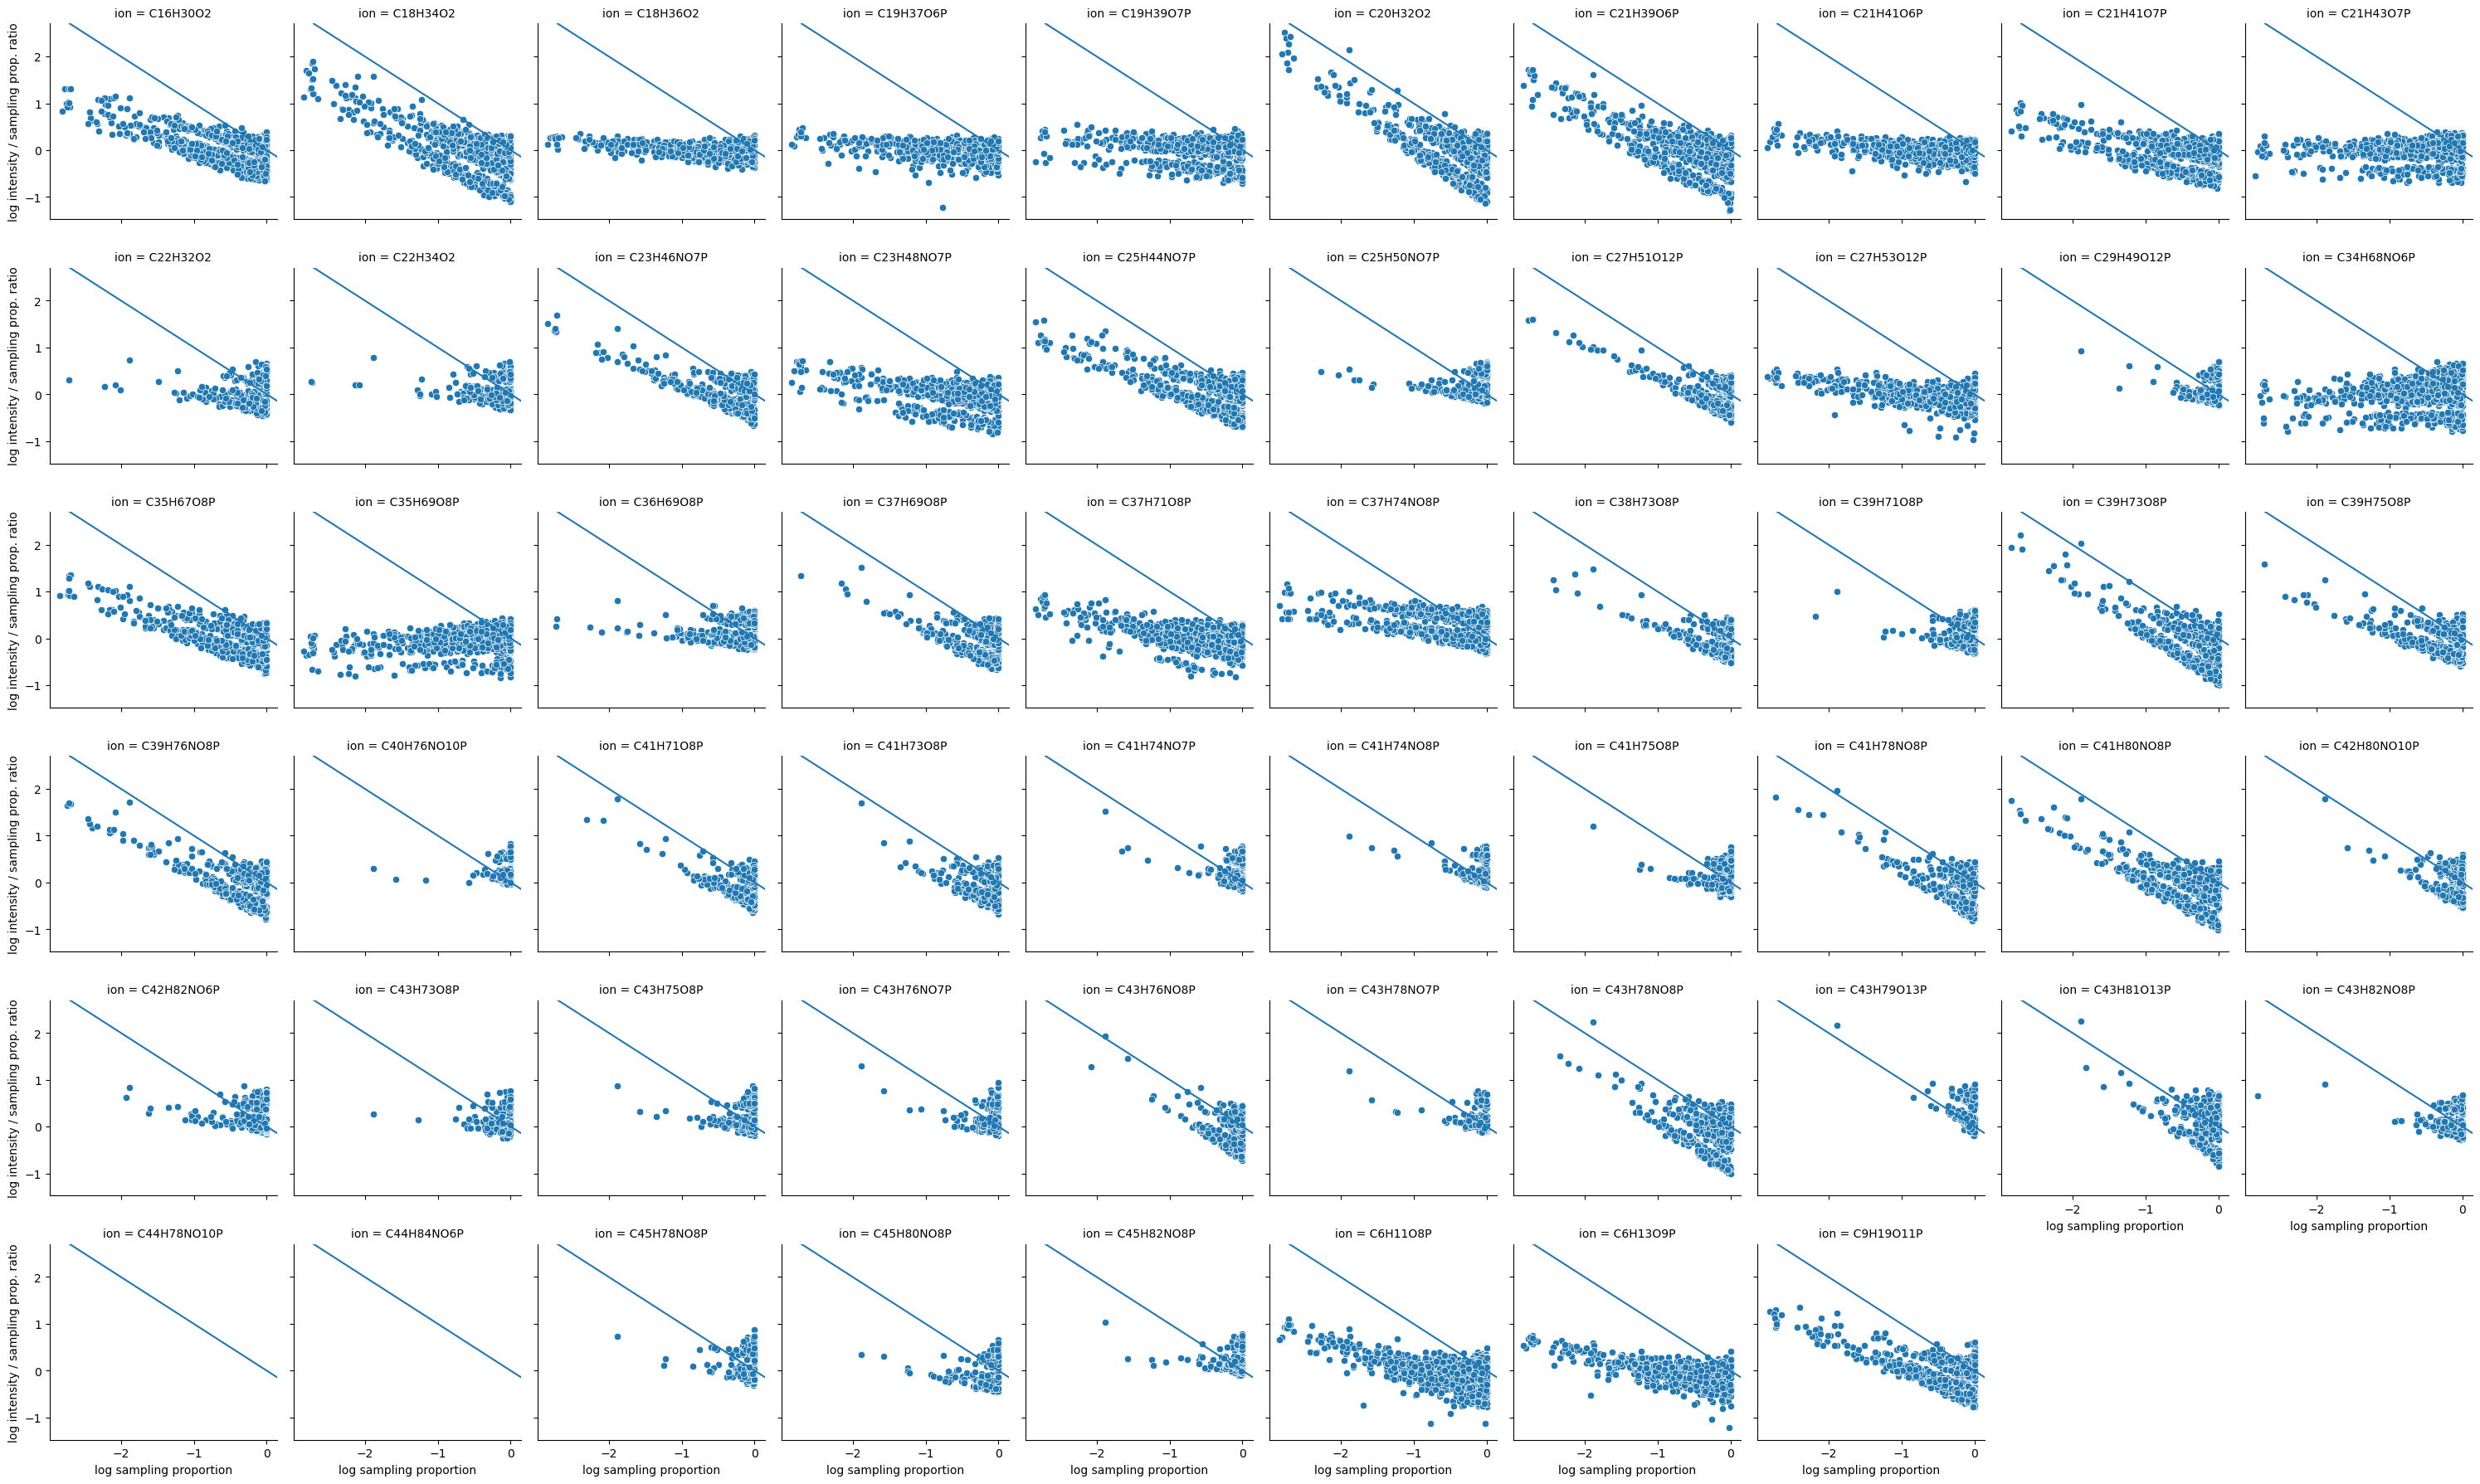

In [22]:
plot_all_ion_slopes(corrected_intensities, subset = raw_adata.var_names)